In [24]:
!pip install deepxde

In [25]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf
import matplotlib.animation as animation
from matplotlib.animation import (
    FuncAnimation,
)

### Parâmetros da Rede Neural, Constantes do Problema e Pesos da Função de Perda

In [26]:
#Pontos de amostragem
SAMPLE_POINTS = 2000

#Condição Inicial e Contorno
T_START = 0
T_END = WIDTH = LENGTH = 1.0

#Constante de difusividade
ALPHA = 0.01

#Rede Neural
ARCHITECTURE = (
    [3] + [60] * 5 + [1]
)
ACTIVATION = "tanh"
INITIALIZER = "Glorot uniform"
LEARNING_RATE = 1e-3
ITERATIONS = 10000  # Número de épocas
OPTIMIZER = "adam"  # Otimizador
BATCH_SIZE = 32

# Pesos dos componentes da função de perda (!!!)
LOSS_WEIGHTS = [
    10, #pde
    1,
    1,
    1,
    10, #up
    10, #ic
]  

### Equação Diferencial

In [27]:
def pde(X, T):
    dT_xx = dde.grad.hessian(T, X, i=0, j=0)
    dT_yy = dde.grad.hessian(T, X, i=1, j=1)

    dT_t = dde.grad.jacobian(T, X, j=2)

    return dT_t - ALPHA * (dT_xx + dT_yy)

### Condições de Contorno

In [28]:
def boundary_right(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, WIDTH)


def boundary_left(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, 0)


def boundary_top(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, LENGTH)


def boundary_bottom(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, 0)

### Condição inicial

In [29]:
def boundary_initial(X, on_initial):
    _, _, t = X
    return on_initial and np.isclose(t, 0)

# Função para inicializar o tempo da condição inicial
def init_func(X):
    t = np.zeros((len(X), 1))
    return t

In [30]:
#Função para inicializar a temperatura da condição de contorno superior como sendo 1
def constraint_top(X):
    return np.ones((len(X), 1))

#Função para inicializar o restante das temperaturas como sendo 0
def func_zero(X):
    return np.zeros(
        (len(X), 1)
    )

### Definindo geometrias e os contornos no Deepxde

In [31]:
geom = dde.geometry.Rectangle([0, 0], [WIDTH, LENGTH])
timedomain = dde.geometry.TimeDomain(0, T_END) 
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [32]:
bc_l = dde.DirichletBC(geomtime, func_zero, boundary_left)
bc_r = dde.DirichletBC(geomtime, func_zero, boundary_right)
bc_up = dde.DirichletBC(geomtime, constraint_top, boundary_top)
bc_low = dde.DirichletBC(geomtime, func_zero, boundary_bottom)
ic = dde.IC(geomtime, init_func, boundary_initial)

### Estabelecendo quais os dados a rede utilizará


In [33]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l, bc_r, bc_low, bc_up, ic],
    num_domain=int(SAMPLE_POINTS),
    num_boundary=int(SAMPLE_POINTS / 4),
    num_initial=int(SAMPLE_POINTS / 2),
)

### Definição da Rede e treinamento

In [34]:
net = dde.maps.FNN(ARCHITECTURE, ACTIVATION, INITIALIZER)

# aplica na saída para pegar a temperatura em módulo
net.apply_output_transform(lambda _, y: abs(y)) 

model = dde.Model(data, net)
model.compile(OPTIMIZER, lr=LEARNING_RATE, loss_weights=LOSS_WEIGHTS)

Compiling model...
Building feed-forward neural network...
'build' took 0.125011 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.508516 s



In [35]:
# Train the model
losshistory, trainstate = model.train(
    iterations=ITERATIONS,
    batch_size=BATCH_SIZE,
)

Training model...

0         [3.92e-01, 2.06e-02, 1.59e-01, 7.19e-02, 5.46e+00, 3.50e-01]    [3.92e-01, 2.06e-02, 1.59e-01, 7.19e-02, 5.46e+00, 3.50e-01]    []  
1000      [1.91e-02, 3.75e-02, 3.70e-02, 1.67e-03, 8.13e-02, 2.05e-01]    [1.91e-02, 3.75e-02, 3.70e-02, 1.67e-03, 8.13e-02, 2.05e-01]    []  
2000      [8.19e-03, 3.81e-02, 3.55e-02, 3.43e-05, 1.99e-02, 4.34e-02]    [8.19e-03, 3.81e-02, 3.55e-02, 3.43e-05, 1.99e-02, 4.34e-02]    []  
3000      [8.41e-03, 3.41e-02, 3.16e-02, 2.68e-05, 2.23e-02, 1.41e-02]    [8.41e-03, 3.41e-02, 3.16e-02, 2.68e-05, 2.23e-02, 1.41e-02]    []  
4000      [8.14e-03, 3.25e-02, 3.08e-02, 2.56e-05, 2.11e-02, 6.70e-03]    [8.14e-03, 3.25e-02, 3.08e-02, 2.56e-05, 2.11e-02, 6.70e-03]    []  
5000      [3.37e-03, 3.40e-02, 3.33e-02, 2.39e-06, 5.46e-03, 6.33e-03]    [3.37e-03, 3.40e-02, 3.33e-02, 2.39e-06, 5.46e-03, 6.33e-03]    []  
6000      [1.13e-02, 3.46e-02, 3.45e-02, 2.66e-05, 9.09e-03, 8.12e-03]    [1.13e-02, 3.46e-02, 3.45e-02, 2.66e-05, 9.09e-03

In [36]:
model.compile("L-BFGS-B", loss_weights=LOSS_WEIGHTS)
losshistory, train_state = model.train(batch_size=BATCH_SIZE)

Compiling model...
'compile' took 0.920092 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
10000     [3.21e-03, 3.11e-02, 3.07e-02, 8.43e-07, 3.93e-03, 2.54e-03]    [3.21e-03, 3.11e-02, 3.07e-02, 8.43e-07, 3.93e-03, 2.54e-03]    []  
11000     [4.15e-03, 2.76e-02, 2.62e-02, 1.90e-06, 3.05e-03, 4.64e-04]    [4.15e-03, 2.76e-02, 2.62e-02, 1.90e-06, 3.05e-03, 4.64e-04]        
12000     [3.85e-03, 2.72e-02, 2.33e-02, 1.62e-06, 3.02e-03, 2.12e-04]    [3.85e-03, 2.72e-02, 2.33e-02, 1.62e-06, 3.02e-03, 2.12e-04]        
13000     [3.32e-03, 2.56e-02, 2.07e-02, 1.05e-06, 4.46e-03, 1.33e-04]    [3.32e-03, 2.56e-02, 2.07e-02, 1.05e-06, 4.46e-03, 1.33e-04]        
14000     [3.23e-03, 2.41e-02, 1.64e-02, 9.72e-07, 5.81e-03, 9.16e-05]    [3.23e-03, 2.41e-02, 1.64e-02, 9.72e-07, 5.81e-03, 9.16e-05]        


KeyboardInterrupt: 

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


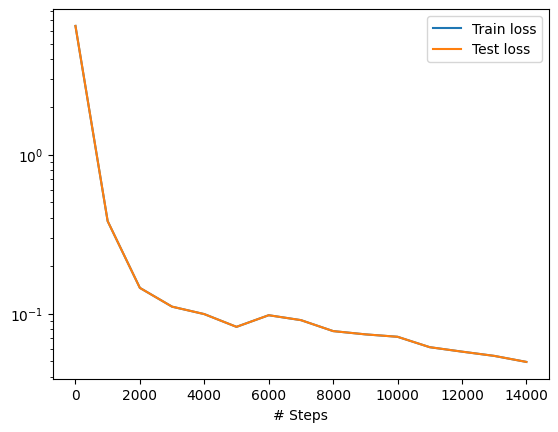

In [37]:
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)
plt.show()
plt.savefig("loss_history_plot_Heat2d")
plt.close()

### Animação

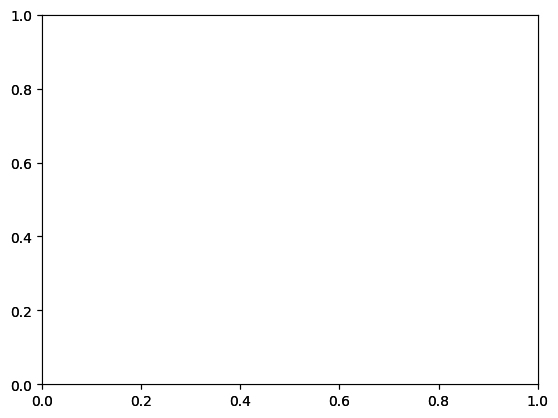

In [38]:
fig, ax = plt.subplots()
ax = fig.add_subplot(111)

nelx = 100  # Número de elementos em x
nely = 100  # Número de elementos em y
timesteps = 101  

x = np.linspace(0, 1, nelx + 1)  
y = np.linspace(0, 1, nely + 1)  
t = np.linspace(0, 1, timesteps)

# Dados pra serem usados na predição
test_x, test_y, test_t = np.meshgrid(x, y, t)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_y), np.ravel(test_t))).T

In [39]:
# Predição da solução
predicted_solution = model.predict(test_domain)
predicted_solution = predicted_solution.reshape(
    test_x.shape
)  

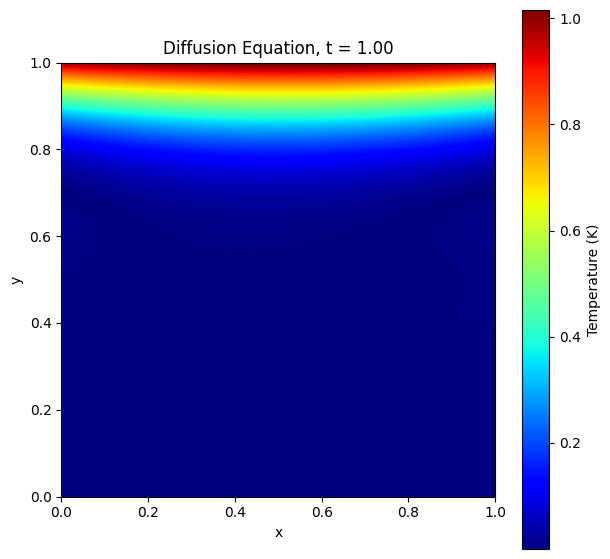

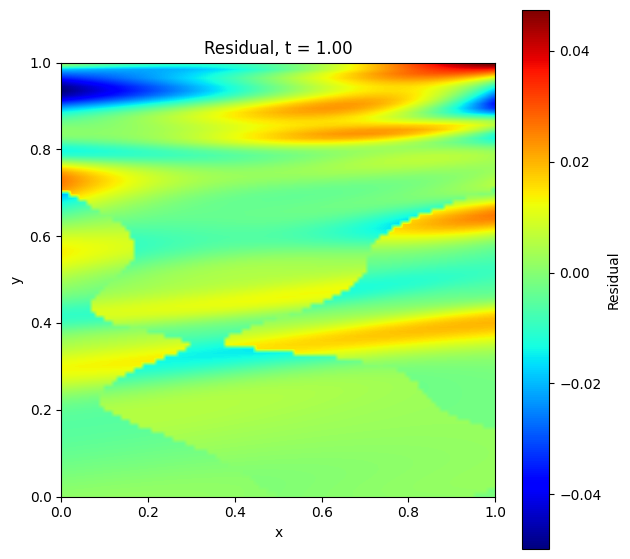

In [40]:
def animate_solution(data, filename, title, label, t_data):
    fig, ax = plt.subplots(figsize=(7, 7))

    # Cria a imagem inicial com a barra de cores
    im = ax.imshow(
        data[:, :, 0],
        origin="lower",
        cmap="jet",
        interpolation="bilinear",
        extent=[0, 1, 0, 1],
    )
    cb = plt.colorbar(im, ax=ax, label=label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Atualiza os frames
    def updatefig(k):
        # Atualiza a imagem em si
        im.set_array(data[:, :, k])
        im.set_clim(
            vmin=data[:, :, k].min(), vmax=data[:, :, k].max()
        )  # Atualiza também as cores limitantes

        cb.update_normal(im)

        ax.set_title(f"{title}, t = {t_data[k]:.2f}")

        return [im]

    ani = animation.FuncAnimation(
        fig, updatefig, frames=range(data.shape[2]), interval=50, blit=True
    )
    ani.save(filename, writer="ffmpeg")


animate_solution(
    predicted_solution,
    f"pinn_heat2d_solution_alpha_{str(ALPHA)}.mp4",
    "Diffusion Equation",
    "Temperature",
    t,
)

### Diferenças Finitas para comparação

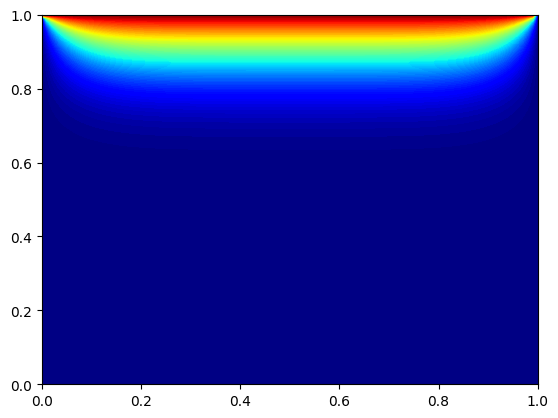

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Domain parameters
W = 1
H = 1
Nx = 101
Ny = 101
ALPHA = 0.01

# Discretization
dx = W / (Nx - 1)
dy = H / (Ny - 1)
dt = min(dx**2, dy**2) / (4 * ALPHA)
total_time = 1

# Mesh grid
x = np.linspace(0, W, Nx)
y = np.linspace(0, H, Ny)
X, Y = np.meshgrid(x, y)

# Initial condition
T = np.zeros((Nx, Ny))

# Time-stepping loop for animation
time = 0
frames = []
fig, ax = plt.subplots()

def update(T):
    T_new = T.copy()
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            T_new[i, j] = T[i, j] + ALPHA * dt * (
                (T[i + 1, j] - 2 * T[i, j] + T[i - 1, j]) / dx**2
                + (T[i, j + 1] - 2 * T[i, j] + T[i, j - 1]) / dy**2
            )
    # Neumann boundary conditions
    T_new[0, :] = 0#T_new[1, :]
    T_new[:, 0] = 0#T_new[:, 1]
    T_new[:, -1] = 1#T_new[:, -2]
    # Dirichlet boundary condition
    T_new[-1, :] = 0  # Using -1 to refer to the last row

    return T_new

while time < total_time:
    T = update(T)
    time += dt
    frames.append(T.copy())

def animate(i):
    ax.clear()
    contour = ax.contourf(X, Y, frames[i].T, cmap="jet", levels=100, vmin=0, vmax=1)
    return contour

ani = animation.FuncAnimation(fig, animate, frames=len(frames), repeat=False)
ani.save("heat_distribution_animation.mp4", writer='ffmpeg', fps=30)

plt.show()
